In [1]:
import spacy
from spacy.tokens import DocBin
import json
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_md')

In [2]:
#Load tweet data

load_pickletweet = pickle.load(open('tweets.p','rb'))
doc_bin = DocBin().from_bytes(load_pickletweet)
tl = list(doc_bin.get_docs(nlp.vocab))

date = pd.read_excel('tweets.xls', usecols=[0])
date = pd.to_datetime(date['created_at']).dt.date

In [3]:
#Load financial data

def get_labels(df):
    #Convert stock market prices to ups(1) and downs(0) based on the close prices
    
    return (df['Close'].shift(-1) > df['Close']) * 1

df_stock = pd.read_excel('S&P 500.xls')
y = get_labels(df_stock)
df_stock['up'] = y
df_stock['Date'] = pd.to_datetime(df_stock['Date']).dt.date

In [4]:
#Join tweets data with date

tweets = [tweet.vector for tweet in tl]
X = pd.DataFrame(tweets)

#Treat each tweet dependently
X['created_at'] = date

#Aggregate the vectors of tweets within each day
#X = X.groupby(date).mean()
#X = X.reset_index()

#Get the label for each date in X
#Here for the sake of simplicty I drop all the nan values
X = pd.merge(X, df_stock[['Date', 'up']], how='inner', left_on=['created_at'], right_on=['Date'])

#Get the final X and y
y = X['up']
X = X.drop(['created_at', 'up', 'Date'], axis=1)

In [15]:
#Cross Validation for random forest

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 200)

print(cross_validate(model, X, y, cv=5, scoring='f1_macro'))

KeyboardInterrupt: 

In [16]:
#Cross Validation for KNN
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

for x in range(1, 4, 1):
    model = KNeighborsClassifier(n_neighbors=x)
    print('n =', x)
    print(cross_validate(model, X, y, cv=5, scoring='f1_macro'))

n = 1
{'fit_time': array([0.72258902, 0.69171929, 0.67962503, 0.68125463, 0.66963553]), 'score_time': array([76.2652142 , 75.88569093, 76.44696045, 78.04847813, 79.05687594]), 'test_score': array([0.49873477, 0.50516972, 0.48162765, 0.49009827, 0.5103498 ]), 'train_score': array([0.98090763, 0.9792675 , 0.97669928, 0.98208026, 0.98221037])}
n = 2
{'fit_time': array([0.71187592, 0.69024158, 0.68062854, 0.68903399, 0.6756351 ]), 'score_time': array([76.53597283, 77.52438712, 77.79299092, 77.93513703, 80.93990302]), 'test_score': array([0.47041997, 0.47179128, 0.44226897, 0.46982965, 0.48948989]), 'train_score': array([0.74648016, 0.74715878, 0.74889242, 0.7519446 , 0.74961938])}
n = 3


KeyboardInterrupt: 

In [ ]:
#Cross Validation for SVM

model = RandomForestClassifier(n_estimators = 200)

print(cross_validate(model, X, y, cv=5, scoring='f1_macro'))

# A probabilistic approach

In [17]:
# Use random forest as an illustration example
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 300)
model.fit(X[::2], y[::2])

model.predict_proba(X[::2])
# model.score(X[::2], y[::2])

0.9855584479980166

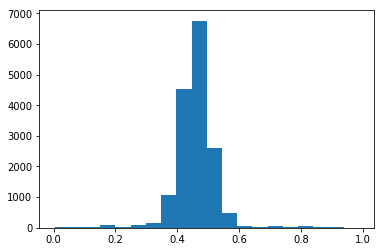

In [18]:
# Plot the prediction confidence 
y_p = model.predict_proba(X[1::2])[:,0]
plt.hist(y_p, bins=20)
plt.show()

In [19]:
#Filter out predictions whose probability is greather than t
t = 0.55
mask = np.all([y_p > 0.5, 1-y_p > 0.5])

# model.score(X[1::2][y_p>t], y[1::2][y_p>t])

0.5455950540958269

In [65]:
#Tweets about which our model is most confident to make predictions
mask2 = np.argsort(y_p)
df_tweets = pd.Series(tl)
most_confi = X[1::2].iloc[mask2].iloc[10000]
for t in range(len(tweets)):
    tweet = tweets[t]
    if (tweet == most_confi).all():
        print(tl[t])

"@leebestt: @realDonaldTrump His opponent should not agree to any debates as I am sure he is a master."  Re me?  Thanks!


# 2D representation of our tweets

In [5]:
from sklearn.manifold import TSNE

In [6]:
transformer = TSNE()

In [14]:
n_tweets = 10000
X_2d = transformer.fit_transform(X[:n_tweets])

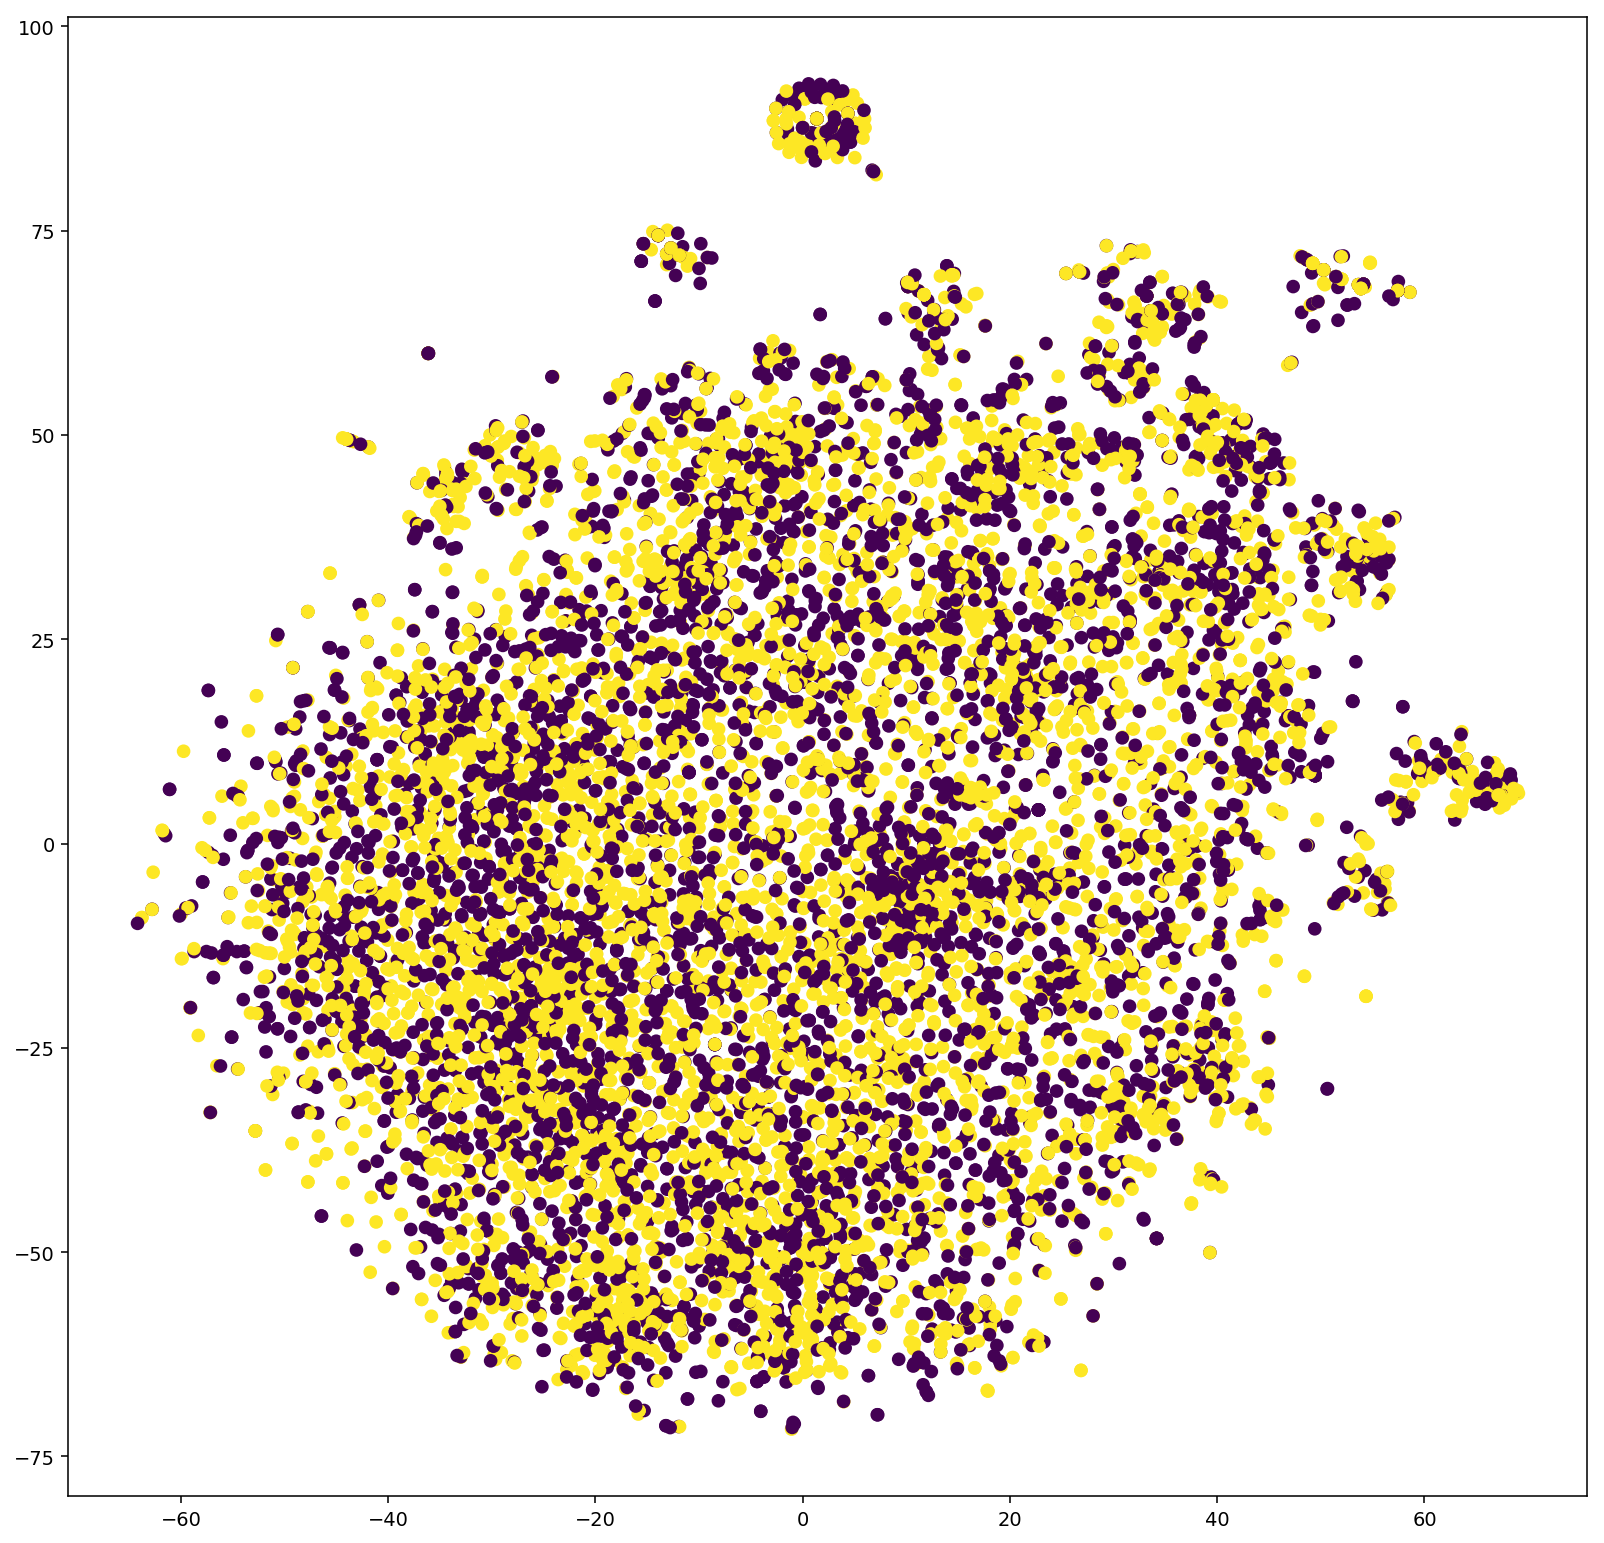

In [15]:
plt.figure(figsize=(14, 14), dpi=140)
plt.scatter(X_2d[:,0], X_2d[:,1], c=y[:n_tweets])
plt.show()